### This notebook requires Python >= 3.6 and fastai==1.0.52

## Objective

In this notebook we will finetune BERT model on The Microsoft Research Paraphrase Corpus (MRPC). MRPC is a paraphrase identification dataset, where systems aim to identify if two sentences are paraphrases of each other.

### Pre-trained Model

We will use op-for-op PyTorch reimplementation of Google's BERT model provided by pytorch-pretrained-BERT library. Refer the Github repo for more info: https://github.com/huggingface/pytorch-pretrained-BERT 

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# This repo contains useful classes to use BERT with FastAI

#! git clone https://github.com/deepklarity/fastai-bert-finetuning.git fastai_bert_finetuning

In [3]:
import csv
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *
from fastai_bert_finetuning import utils, bert_fastai, bert_helper

In [4]:
# Seed random generators so all model runs are reproducible

utils.seed_everything()

### Using BERT with fastai

There are three things we need to be careful of when using BERT with fastai:

   1. BERT uses its own wordpiece tokenizer.
    
   [WordPiece](https://stackoverflow.com/questions/55382596/how-is-wordpiece-tokenization-helpful-to-effectively-deal-with-rare-words-proble/55416944#55416944) is a commonly used technique to segment words into subword-level in NLP tasks.
       The vocabulary is initialized with all the individual characters in the language, and
       then the most frequent/likely combinations of the symbols in the vocabulary are iteratively
       added to the vocabulary.
       
   **How does this help?**

  Imagine that the model sees the word walking. Unless this word occurs at least a few times in the
training corpus, the model can't learn to deal with this word very well. However, it may have the
words walked, walker, walks, each occurring only a few times. Without subword segmentation, all these
words are treated as completely different words by the model.
However, if these get segmented as walk@@ ing, walk@@ ed, etc., notice that all of them will now have
walk@@ in common, which will occur much frequently while training, and the model might be able to
learn more about it.
   
   2. BERT needs [CLS] and [SEP] tokens added to each sequence.
    
  For classification tasks we need to add [CLS] token before every input sequence.
[SEP] token is used to separate sentences.
    
   3. BERT uses its own pre-built vocabulary.


### Mask Language Model Demo

We will load a BERT model with the masked language modeling head and predict masked words.

In [5]:
bert_token_model = bert_helper.BertMaskedLM()

In [6]:
text = '[CLS] Steve Jobs founded [MASK] . [SEP][CLS] Microsoft makes [MASK] . [SEP]'
preds = bert_token_model.predict_tokens(text)
for p in preds: print(p)

[CLS] Steve Jobs founded apple .  [SEP]
[CLS] Microsoft makes windows .  [SEP]


In [7]:
del bert_token_model

### Dataset

MRPC dataset a text file containing 5800 pairs of sentences which have been extracted from news sources on the web, along with human annotations indicating whether each pair captures a paraphrase/semantic equivalence relationship. The column named **Quality** indicates whether the sentences are similar (1) or not (0). **"#1 String" and "#2 String"** columns contain the sentences.

In [8]:
# https://www.microsoft.com/en-us/download/details.aspx?id=52398
# Microsoft Research Paraphrase Corpus
TASK='MRPC'
DATA_ROOT = Path(".")
label_col = "Quality"
text_cols = ["#1 String", "#2 String"]


In [9]:
# Execute script to download MRPC data and create train.csv and test.csv

! python fastai_bert_finetuning/download_glue_data.py --data_dir='glue_data' --tasks=$TASK --test_labels=True

Processing MRPC...
Local MRPC data not specified, downloading data from https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt
	Completed!


In [10]:
train_df = pd.read_csv(DATA_ROOT / "glue_data" / "MRPC" / "train.tsv", sep = '\t', quoting=csv.QUOTE_NONE)
train_df.head()

,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,702876,702977,"Amrozi accused his brother , whom he called "" ...","Referring to him as only "" the witness "" , Amr..."
1,0,2108705,2108831,Yucaipa owned Dominick 's before selling the c...,Yucaipa bought Dominick 's in 1995 for $ 693 m...
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10 , the ship 's owners had published ..."
3,0,3344667,3344648,"Around 0335 GMT , Tab shares were up 19 cents ...","Tab shares jumped 20 cents , or 4.6 % , to set..."
4,1,1236820,1236712,"The stock rose $ 2.11 , or about 11 percent , ...",PG & E Corp. shares jumped $ 1.63 or 8 percent...


In [11]:
test_df = pd.read_csv(DATA_ROOT / "glue_data" / "MRPC" / "test.tsv", sep = '\t', quoting=csv.QUOTE_NONE)
test_df.head()

,index,Quality,#1 ID,#2 ID,#1 String,#2 String
0,0,1,1089874,1089925,"PCCW 's chief operating officer , Mike Butcher...",Current Chief Operating Officer Mike Butcher a...
1,1,1,3019446,3019327,The world 's two largest automakers said their...,Domestic sales at both GM and No. 2 Ford Motor...
2,2,1,1945605,1945824,According to the federal Centers for Disease C...,The Centers for Disease Control and Prevention...
3,3,0,1430402,1430329,A tropical storm rapidly developed in the Gulf...,A tropical storm rapidly developed in the Gulf...
4,4,0,3354381,3354396,The company didn 't detail the costs of the re...,But company officials expect the costs of the ...


In [12]:
print(f"Number of Training records={len(train_df)}")
print(f"Number of Test records={len(test_df)}")

Number of Training records=3668
Number of Test records=1725


In [13]:
def sample_sentences(quality, n=5):
    ctr = 0
    for row in train_df.query(f'Quality=={quality}').itertuples():
        print(f"1. {row[4]}\n2. {row[5]}")
        print("="*100)
        ctr += 1
        if n==ctr:
            break


In [14]:
# Different sentences samples            
sample_sentences(0)

1. Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .
2. Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .
1. Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .
2. Tab shares jumped 20 cents , or 4.6 % , to set a record closing high at A $ 4.57 .
1. The Nasdaq had a weekly gain of 17.27 , or 1.2 percent , closing at 1,520.15 on Friday .
2. The tech-laced Nasdaq Composite .IXIC rallied 30.46 points , or 2.04 percent , to 1,520.15 .
1. That compared with $ 35.18 million , or 24 cents per share , in the year-ago period .
2. Earnings were affected by a non-recurring $ 8 million tax benefit in the year-ago period .
1. Shares of Genentech , a much larger company with several products on the market , rose more than 2 percent .
2. Shares of Xoma fell 16 percent in early trade , while shares of Genentech , a much larger company with se

In [15]:
# Similar sentences samples            
sample_sentences(1)

1. Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .
2. Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .
1. They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .
2. On June 10 , the ship 's owners had published an advertisement on the Internet , offering the explosives for sale .
1. The stock rose $ 2.11 , or about 11 percent , to close Friday at $ 21.51 on the New York Stock Exchange .
2. PG & E Corp. shares jumped $ 1.63 or 8 percent to $ 21.03 on the New York Stock Exchange on Friday .
1. Revenue in the first quarter of the year dropped 15 percent from the same period a year earlier .
2. With the scandal hanging over Stewart 's company , revenue the first quarter of the year dropped 15 percent from the same period a year earlier .
1. The DVD-CCA then appealed to the state Supreme Court .
2. The DVD CCA appealed that 

### Setup code for training

In [16]:
# Specify BERT configs

config = utils.Config(
    bert_model_name="bert-base-uncased",
    num_labels=2, # 0 or 1
    max_lr=2e-5,
    epochs=3,
    batch_size=32,
    max_seq_len=128
)

In [17]:
fastai_tokenizer = bert_fastai.FastAITokenizer(model_name=config.bert_model_name, max_seq_len=config.max_seq_len)

Now, we can build the databunch using the tokenizer we build above. Notice we're passing the `include_bos=False` and `include_eos=False` options. This is to prevent fastai from adding its own Start-Of-Sentence (SOS)/End-Of-Sentence (EOS) tokens that will interfere with BERT's SOS/EOS tokens.

In [18]:
databunch = TextDataBunch.from_df(".", train_df=train_df, valid_df=test_df,
                  tokenizer=fastai_tokenizer.bert_tokenizer(),
                  vocab=fastai_tokenizer.fastai_bert_vocab(),
                  include_bos=False,
                  include_eos=False,
                  text_cols=text_cols,
                  label_cols=label_col,
                  bs=config.batch_size,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )


In [19]:
# Show wordpiece tokenized data

for i in range(5): 
    print(f"Original==> {train_df.loc[i][text_cols[0]]},{train_df.loc[i][text_cols[1]]}\n\nTokenized==>. {databunch.x[i]}")
    print("="*100)

Original==> Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .,Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .

Tokenized==>. [CLS] am ##ro ##zi accused his brother , whom he called " the witness " , of deliberately di ##stor ##ting his evidence . referring to him as only " the witness " , am ##ro ##zi accused his brother of deliberately di ##stor ##ting his evidence . [SEP]
Original==> Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .,Yucaipa bought Dominick 's in 1995 for $ 693 million and sold it to Safeway for $ 1.8 billion in 1998 .

Tokenized==>. [CLS] yu ##ca ##ip ##a owned dominic ##k ' s before selling the chain to safe ##way in 1998 for $ 2 . 5 billion . yu ##ca ##ip ##a bought dominic ##k ' s in 1995 for $ 69 ##3 million and sold it to safe ##way for $ 1 . 8 billion in 1998 . [SEP]
Original==> They had published an adver

# Model

Now with the data in place, we will prepare the model. Again, the pytorch-pretrained-bert package gives us a sequence classifier based on BERT straight out of the box. We also build FastAI `Learner`.

In [20]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification

def bert_learner():

    bert_model = BertForSequenceClassification.from_pretrained(
        config.bert_model_name, num_labels=config.num_labels)

    learner = bert_fastai.BertLearner(databunch,
                                      bert_model,
                                      metrics=[accuracy])

    learner.callbacks.append(ShowGraph(learner))
    return learner

In [21]:
learner = bert_learner()

Let's print the accuracy and f1_score of the pre-trained model on this dataset

In [22]:
preds, pred_values, true_labels = learner.get_predictions()
learner.print_metrics(preds, pred_values, true_labels)

Accuracy=0.5281159281730652, f1_score=0.6238447319778189


Interpret the results

In [23]:
txt_ci = TextClassificationInterpretation.from_learner(learner)

In [24]:
utils.custom_show_top_losses(txt_ci, test_df, text_cols, 5)

Index,Original Text,Tokenized,Prediction,Actual,Loss,Probability
14,"Evidence suggests two of the victims were taken by surprise , while the other two might have tried to flee or to defend themselves or the others , police said .,Evidence suggests two victims were taken by surprise , while the others may have tried to flee or perhaps defend themselves or their friends , police said .","[CLS] evidence suggests two of the victims were taken by surprise , while the other two might have tried to flee or to defend themselves or the others , police said . evidence suggests two victims were taken by surprise , while the others may have tried to flee or perhaps defend themselves or their friends , police said . [SEP]",0,1,0.94,0.39
658,"In an E-mail statement to the Knoxville News Sentinel , Shumaker said , ' ' I am not giving any consideration to resignation .,I am not giving any consideration to resignation , "" Shumaker said in a statement .","[CLS] in an e - mail statement to the knoxville news sentinel , shu ##maker said , ' ' i am not giving any consideration to resignation . i am not giving any consideration to resignation , "" shu ##maker said in a statement . [SEP]",0,1,0.93,0.39
962,""" I expect Japan to keep conducting intervention , but the volume is likely to fall sharply , "" said Junya Tanase , forex strategist at JP Morgan Chase .,Junya Tanase , forex strategist at JP Morgan Chase , said "" I expect Japan to keep conducting intervention , but the volume is likely to fall sharply . ""","[CLS] "" i expect japan to keep conducting intervention , but the volume is likely to fall sharply , "" said jun ##ya tan ##ase , fore ##x st ##rate ##gist at jp morgan chase . jun ##ya tan ##ase , fore ##x st ##rate ##gist at jp morgan chase , said "" i expect japan to keep conducting intervention , but the volume is likely to fall sharply .",0,1,0.93,0.40
531,"The Episcopal Church ' ' is alienating itself from the Anglican Communion , ' ' said the Very Rev. Peter Karanja , provost of the All Saints Cathedral , in Nairobi .,In Nairobi , the provost of All Saints Cathedral , the Very Reverend Peter Karanja , said the US Episcopal Church was alienating itself from the Anglican Communion .","[CLS] the episcopal church ' ' is alien ##ating itself from the anglican communion , ' ' said the very rev . peter kara ##n ##ja , provost of the all saints cathedral , in nairobi . in nairobi , the provost of all saints cathedral , the very reverend peter kara ##n ##ja , said the us episcopal church was alien ##ating itself from the anglican communion . [SEP]",0,1,0.92,0.40
556,"Three Southern politicians who ``stood up to ancient hatreds ' ' were honored Monday with Profile in Courage Awards from the John F. Kennedy Library and Museum .,Barnes is one of three politicians honored Monday by the John F. Kennedy Library and Museum with the Profile in Courage Award .",[CLS] three southern politicians who ` ` stood up to ancient hatred ##s ' ' were honored monday with profile in courage awards from the john f . kennedy library and museum . barnes is one of three politicians honored monday by the john f . kennedy library and museum with the profile in courage award . [SEP],0,0,0.91,0.60


In [25]:
# Print layers which will be trained

learner.print_trainable_layers()

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [26]:
# Let's freeze all layers of pre-trained BERT model and only train the classifier head

learner.freeze_all_layers()
learner.print_trainable_layers()

classifier.weight
classifier.bias


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04


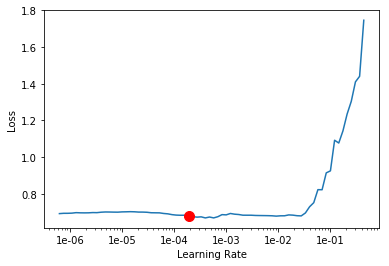

In [27]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.695714,0.692334,0.537391,00:10
1,0.699723,0.691237,0.554203,00:10
2,0.700866,0.690989,0.555362,00:11


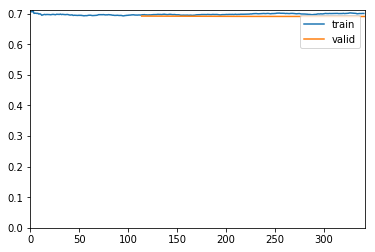

In [28]:
learner.fit_one_cycle(config.epochs, max_lr=1e-07)

In [29]:
preds, pred_values, true_labels = learner.get_predictions()
learner.print_metrics(preds, pred_values, true_labels)

Accuracy=0.555362343788147, f1_score=0.6649191786806466


In [30]:
# BERT base has 12 encoder blocks. Let's freeze first 6 blocks and train

learner.freeze_encoders_to(6)
learner.print_trainable_layers()

bert.encoder.layer.6.attention.self.query.weight
bert.encoder.layer.6.attention.self.query.bias
bert.encoder.layer.6.attention.self.key.weight
bert.encoder.layer.6.attention.self.key.bias
bert.encoder.layer.6.attention.self.value.weight
bert.encoder.layer.6.attention.self.value.bias
bert.encoder.layer.6.attention.output.dense.weight
bert.encoder.layer.6.attention.output.dense.bias
bert.encoder.layer.6.intermediate.dense.weight
bert.encoder.layer.6.intermediate.dense.bias
bert.encoder.layer.6.output.dense.weight
bert.encoder.layer.6.output.dense.bias
bert.encoder.layer.7.attention.self.query.weight
bert.encoder.layer.7.attention.self.query.bias
bert.encoder.layer.7.attention.self.key.weight
bert.encoder.layer.7.attention.self.key.bias
bert.encoder.layer.7.attention.self.value.weight
bert.encoder.layer.7.attention.self.value.bias
bert.encoder.layer.7.attention.output.dense.weight
bert.encoder.layer.7.attention.output.dense.bias
bert.encoder.layer.7.intermediate.dense.weight
bert.encoder.

epoch,train_loss,valid_loss,accuracy,time
0,0.654702,0.638659,0.660870,00:17
1,0.639007,0.636407,0.662609,00:16
2,0.629126,0.635346,0.662609,00:17


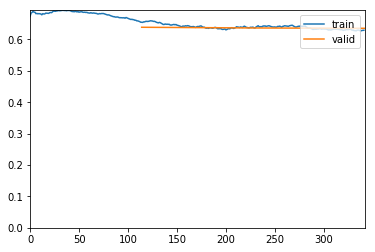

In [31]:
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

In [32]:
preds, pred_values, true_labels = learner.get_predictions()
learner.print_metrics(preds, pred_values, true_labels)

Accuracy=0.6626086831092834, f1_score=0.797071129707113


In [33]:
# Now free only the embeddings layer and train

learner.freeze_embeddings()
learner.print_trainable_layers()

bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.1.attention.self.query.weight
bert.encoder.layer.1.attention.self.query.bias
bert.encoder.layer.1.attention.self.key.weight
bert.encoder.layer.1.attention.self.key.bias
bert.encoder.layer.1.attention.self.value.weight
bert.encoder.layer.1.attention.self.value.bias
bert.encoder.layer.1.attention.output.dense.weight
bert.encoder.layer.1.attention.output.dense.bias
bert.encoder.layer.1.intermediate.dense.weight
bert.encoder.

epoch,train_loss,valid_loss,accuracy,time
0,0.633220,0.634032,0.663188,00:25
1,0.634408,0.632166,0.663188,00:23
2,0.627980,0.631080,0.663188,00:24


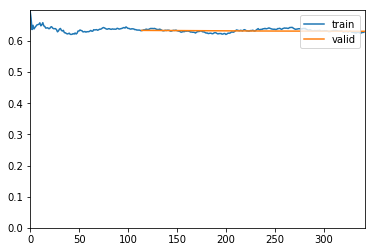

In [34]:
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

In [35]:
preds, pred_values, true_labels = learner.get_predictions()
learner.print_metrics(preds, pred_values, true_labels)

Accuracy=0.6631883978843689, f1_score=0.7974904147786684


In [36]:
learner.unfreeze_all_layers()
learner.print_trainable_layers()

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

epoch,train_loss,valid_loss,accuracy,time
0,0.629427,0.629758,0.662609,00:26
1,0.624226,0.628090,0.662609,00:25
2,0.620744,0.626964,0.662609,00:24


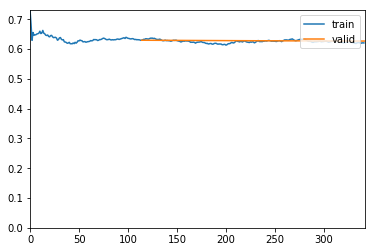

In [37]:
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

### Reload pre-trained model and train all layers

Freezing and unfreezing model layers didn't help in decreasing the loss. Let's reload the model and train all the layers

In [38]:
learner = bert_learner()

In [39]:
preds, pred_values, true_labels = learner.get_predictions()
learner.print_metrics(preds, pred_values, true_labels)

Accuracy=0.3379710018634796, f1_score=0.013816925734024179


epoch,train_loss,valid_loss,accuracy,time
0,0.641554,0.626851,0.664928,00:28
1,0.555538,0.472649,0.775072,00:27
2,0.391211,0.411716,0.815072,00:28
3,0.295702,0.402272,0.821449,00:29


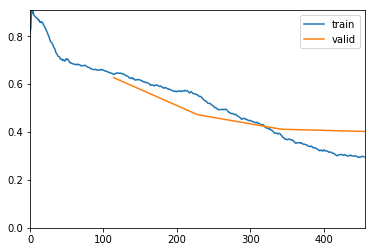

In [40]:
learner.fit_one_cycle(4, max_lr=config.max_lr)

In [41]:
preds, pred_values, true_labels = learner.get_predictions()
learner.print_metrics(preds, pred_values, true_labels)

Accuracy=0.8214492797851562, f1_score=0.8682634730538923


In [42]:
txt_ci = TextClassificationInterpretation.from_learner(learner)

In [43]:
utils.custom_show_top_losses(txt_ci, test_df, text_cols, 10)

Index,Original Text,Tokenized,Prediction,Actual,Loss,Probability
779,"Casteen has been under pressure from Gov. Mark R. Warner and other state officials to do whatever he could to protect Virginia Tech 's athletic viability .,Virginia Gov. Mark R. Warner has been urging other state officials to do whatever they could to protect Virginia Tech 's interests .",[CLS] caste ##en has been under pressure from gov . mark r . warner and other state officials to do whatever he could to protect virginia tech ' s athletic via ##bility . virginia gov . mark r . warner has been urging other state officials to do whatever they could to protect virginia tech ' s interests . [SEP],1,1,4.18,0.98
694,"The fines are part of failed Republican efforts to force or entice the Democrats to return .,Perry said he backs the Senate 's efforts , including the fines , to force the Democrats to return .","[CLS] the fines are part of failed republican efforts to force or en ##tic ##e the democrats to return . perry said he backs the senate ' s efforts , including the fines , to force the democrats to return . [SEP]",1,0,4.11,0.02
653,"He admits that the law "" has several weaknesses which terrorists could exploit , undermining our defenses . "",But he also told the House Judiciary Committee the law "" has several weaknesses which terrorists could exploit , undermining our defenses . ""","[CLS] he admits that the law "" has several weaknesses which terrorists could exploit , under ##mini ##ng our defenses . "" but he also told the house judiciary committee the law "" has several weaknesses which terrorists could exploit , under ##mini ##ng our defenses . "" [SEP]",1,1,4.11,0.98
1294,"Chante Jawan Mallard , 27 , went on trial Monday , charged with first-degree murder .,Chante Jawaon Mallard , 27 , is charged with murder and tampering with evidence .","[CLS] chant ##e jaw ##an mall ##ard , 27 , went on trial monday , charged with first - degree murder . chant ##e jaw ##ao ##n mall ##ard , 27 , is charged with murder and tam ##per ##ing with evidence . [SEP]",1,0,4.08,0.02
1639,"Veteran stage and screen actor Hume Cronyn died of cancer Sunday .,Character actor Hume Cronyn , 91 , died Sunday at his home in Connecticut .","[CLS] veteran stage and screen actor hume cr ##ony ##n died of cancer sunday . character actor hume cr ##ony ##n , 91 , died sunday at his home in connecticut . [SEP]",1,0,3.96,0.02
589,"In that case , the court held that Cincinnati had violated the First Amendment in banning only the advertising pamphlets in the interest of aesthetics .,In that case , the court held that the city of Cincinnati had violated the First Amendment in banning , in the interest of aesthetics , only the advertising pamphlets .","[CLS] in that case , the court held that cincinnati had violated the first amendment in banning only the advertising pamphlets in the interest of aesthetics . in that case , the court held that the city of cincinnati had violated the first amendment in banning , in the interest of aesthetics , only the advertising pamphlets . [SEP]",1,1,3.90,0.98
996,"The 2 1 / 2 -ton probe will plunge into the thick Jovian atmosphere today at 3 : 49 p.m. Eastern time , disintegrating moments later from the friction generated by its 108,000-mph free-fall .,The 2 1 / 2-ton probe will plunge into the thick Jovian atmosphere today at 1 : 49 p.m. MDT , disintegrating moments later from the friction generated by its 108,000 mph free-fall .","[CLS] the 2 1 / 2 - ton probe will plunge into the thick jo ##vian atmosphere today at 3 : 49 p . m . eastern time , di ##sin ##te ##grating moments later from the friction generated by its 108 , 000 - mph free - fall . the 2 1 / 2 - ton probe will plunge into the thick jo ##vian atmosphere today at 1 :",1,1,3.90,0.98
296,"GE stock were up 37 cents to $ 28.56 in morning New York Stock Exchange trade .,Investors reacted little , with GE shares edging 7 cents lower to end at $ 28.12 on the New York Stock Exchange .","[CLS] ge stoc

#### Next Steps

There's major improvement in the accuracy and loss by just running for few epochs. We can improve the model further to acc = 0.8504901960784313 and f1 = 0.8974789915966387 by using the techniques mentioned in the original BERT paper. Refer to https://github.com/huggingface/pytorch-pretrained-BERT#mrpc for details. 